In [ ]:
!pip install opencv-python-headless

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

**Thresholding**

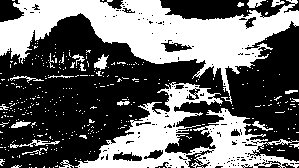

In [ ]:
image = cv2.imread("/img-1.jpg", cv2.IMREAD_GRAYSCALE)
_, thresh = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

cv2_imshow(thresh)

**K-Means Clustering**

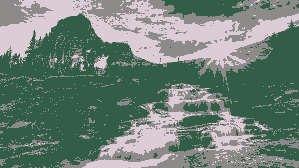

In [ ]:
image = cv2.imread("/img-1.jpg")
Z = image.reshape((-1, 3))
Z = np.float32(Z)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3
_, labels, centers = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

centers = np.uint8(centers)
segmented_image = centers[labels.flatten()].reshape(image.shape)

cv2_imshow(segmented_image)

**Watershed Algorithm**

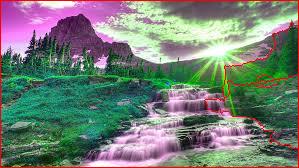

In [ ]:
image = cv2.imread("/img-1.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Remove noise
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Sure background
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Sure foreground
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labeling
_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# Apply Watershed
cv2.watershed(image, markers)
image[markers == -1] = [0, 0, 255]

cv2_imshow(image)

**CNN model for Image Segmentation**

In [ ]:
!pip install tensorflow opencv-python numpy matplotlib

Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6528 - loss: 0.6915
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6528 - loss: 0.6899
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6526 - loss: 0.6883
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6526 - loss: 0.6866
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6526 - loss: 0.6850
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


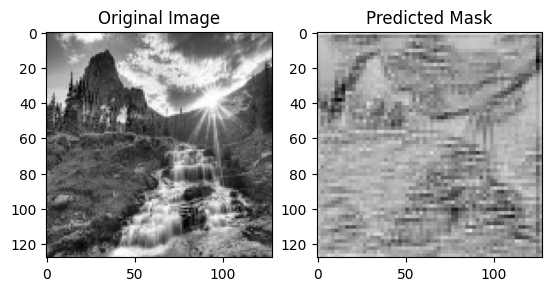

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess image
image = cv2.imread("/img-1.jpg", cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (128, 128))

# Convert the image to 8-bit unsigned integer before applying thresholding
image_8u = image.astype(np.uint8)

# Apply thresholding (Similar to Watershed preprocessing)
_, mask = cv2.threshold(image, 0.5, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Normalize the image after thresholding
image = image / 255.0

# Reshape for CNN
image = np.expand_dims(image, axis=(0, -1))  # Add batch & channel dims
mask = np.expand_dims(mask, axis=(0, -1))

# Simple CNN Model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')
])

# Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train Model
model.fit(image, mask, epochs=5, batch_size=1, verbose=1)

# Predict Segmentation
pred_mask = model.predict(image)[0]

# Display Results
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image[0, :, :, 0], cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Predicted Mask")
plt.imshow(pred_mask[:, :, 0], cmap='gray')

plt.show()